1. IMPORTS & INITIAL SETUP

In [37]:
import numpy as np  # type: ignore
import pandas as pd  # type: ignore
import seaborn as sns  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import missingno as msno  # type: ignore
import statsmodels.api as sm  # type: ignore
from sklearn.preprocessing import StandardScaler  # type: ignore
from sklearn.model_selection import (train_test_split, GridSearchCV,  # type: ignore
                                     cross_val_score, StratifiedKFold)
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score,  # type: ignore
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression  # type: ignore
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor  # type: ignore
from sklearn.svm import SVC  # type: ignore
from sklearn.tree import DecisionTreeClassifier  # type: ignore
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # type: ignore
from xgboost import XGBClassifier  # type: ignore
from sklearn.pipeline import Pipeline  # type: ignore
from sklearn.base import BaseEstimator, TransformerMixin  # type: ignore
import joblib  # type: ignore
import warnings
warnings.simplefilter(action='ignore')

sns.set(style="whitegrid")
plt.style.use("ggplot")
# If using in Jupyter, uncomment the next line:
# %matplotlib inline

2. DATA LOADING & INITIAL EDA

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Descriptive Statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469  

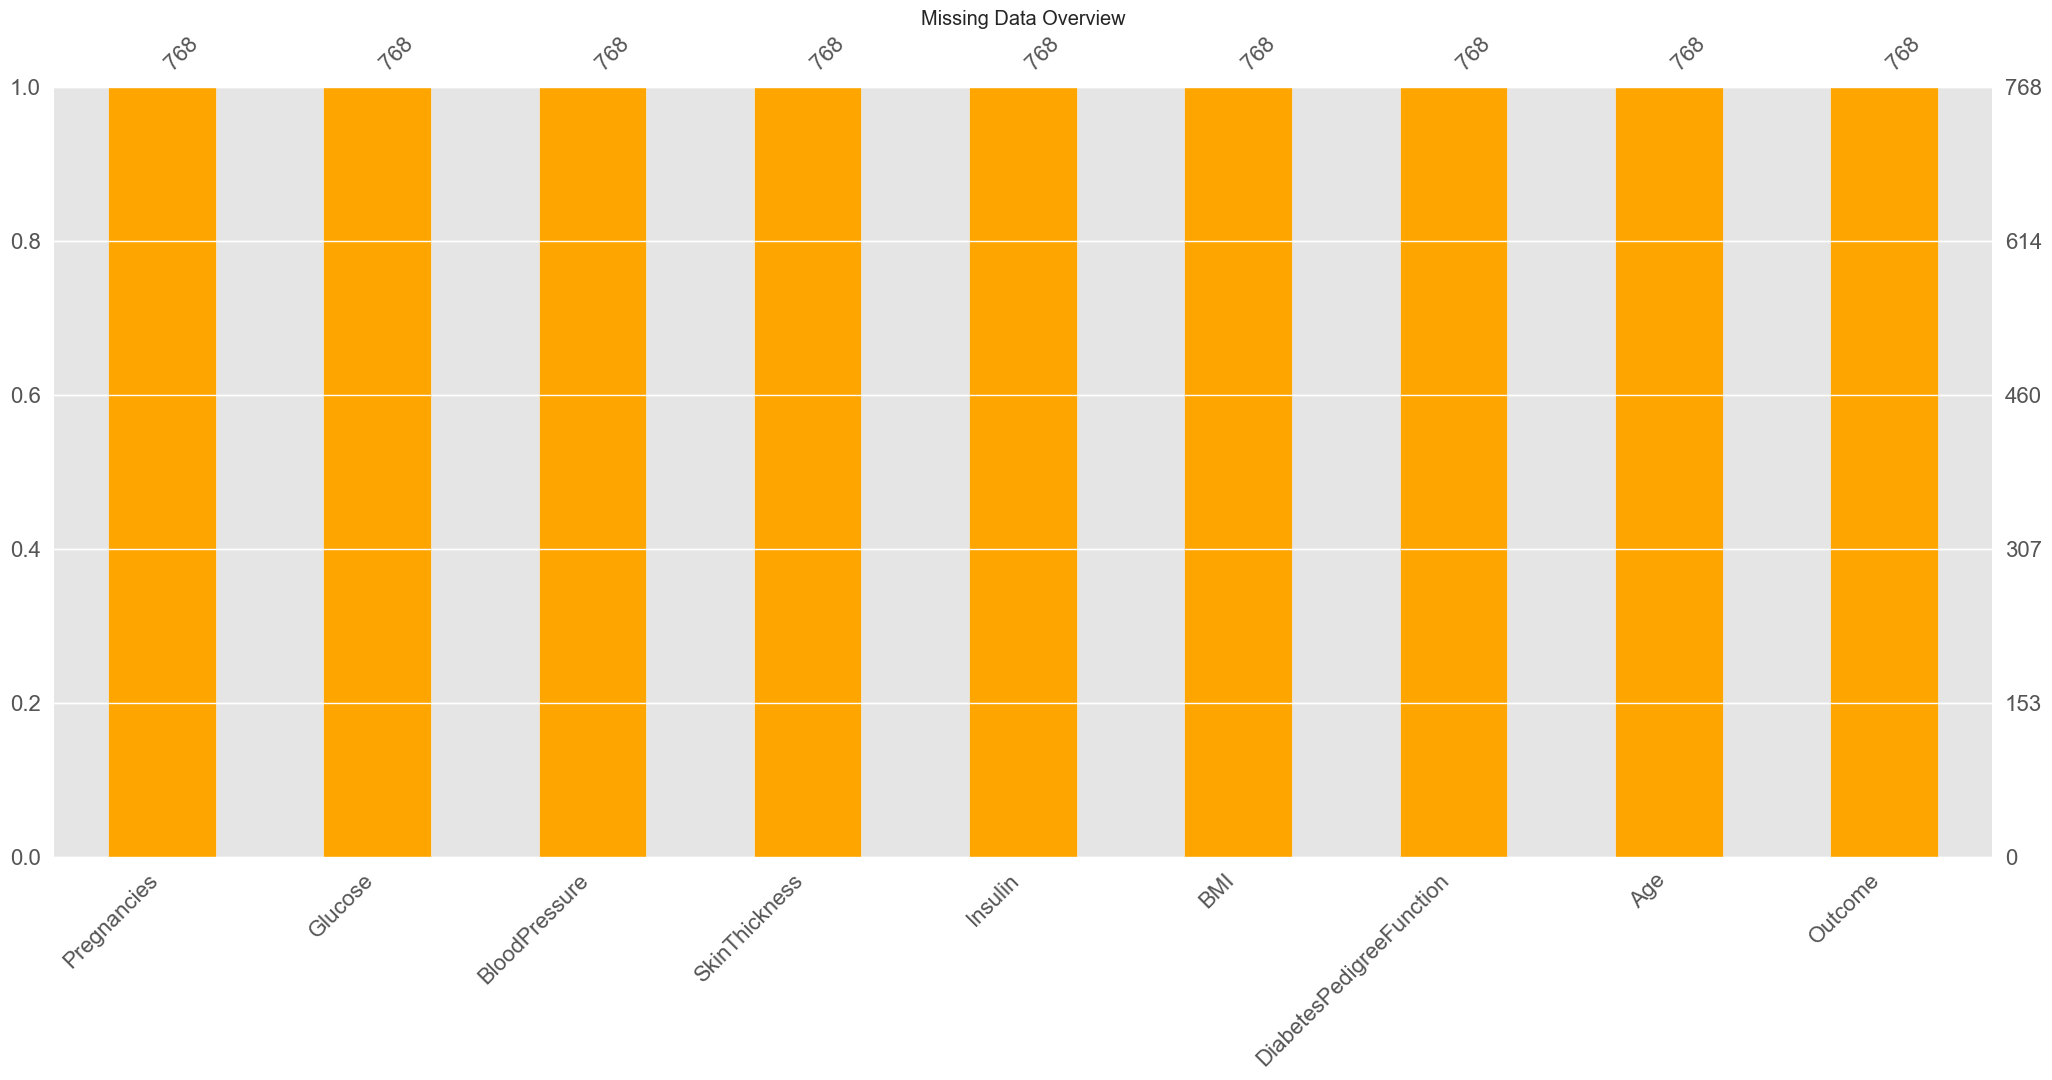

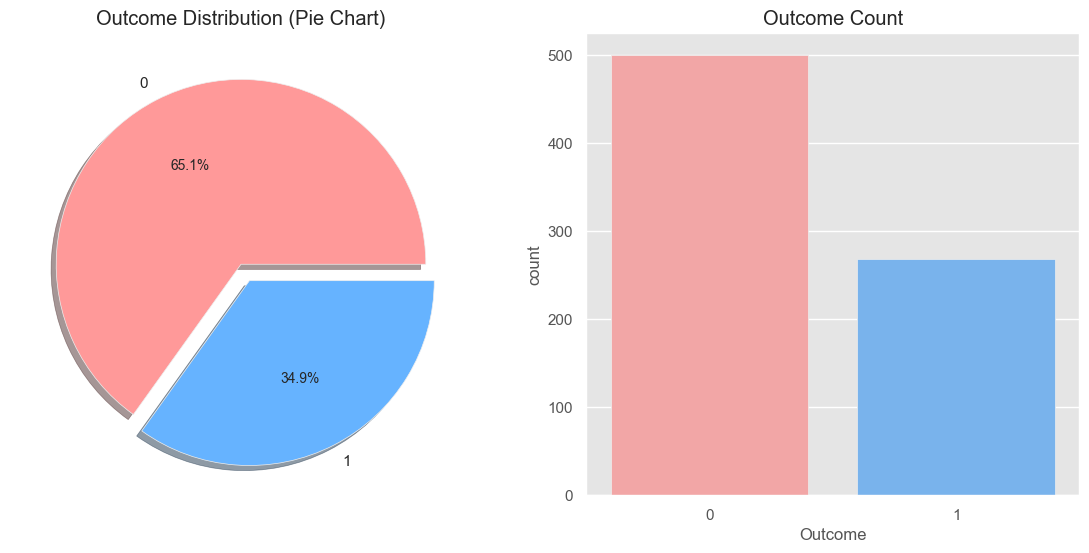

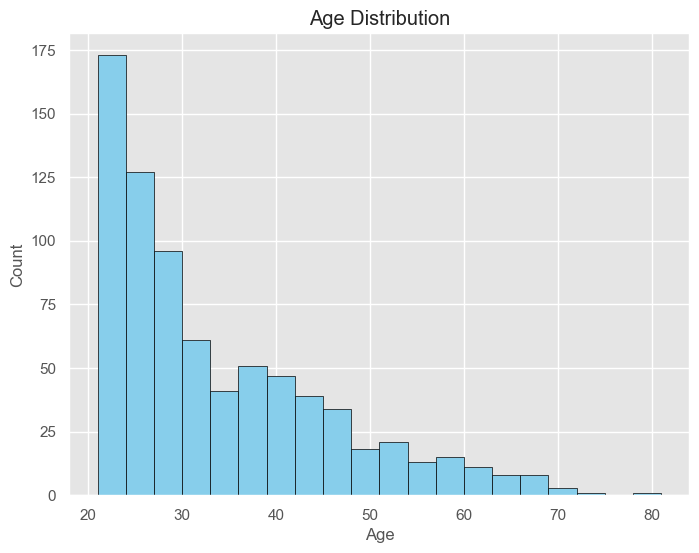

Max Age: 81
Min Age: 21


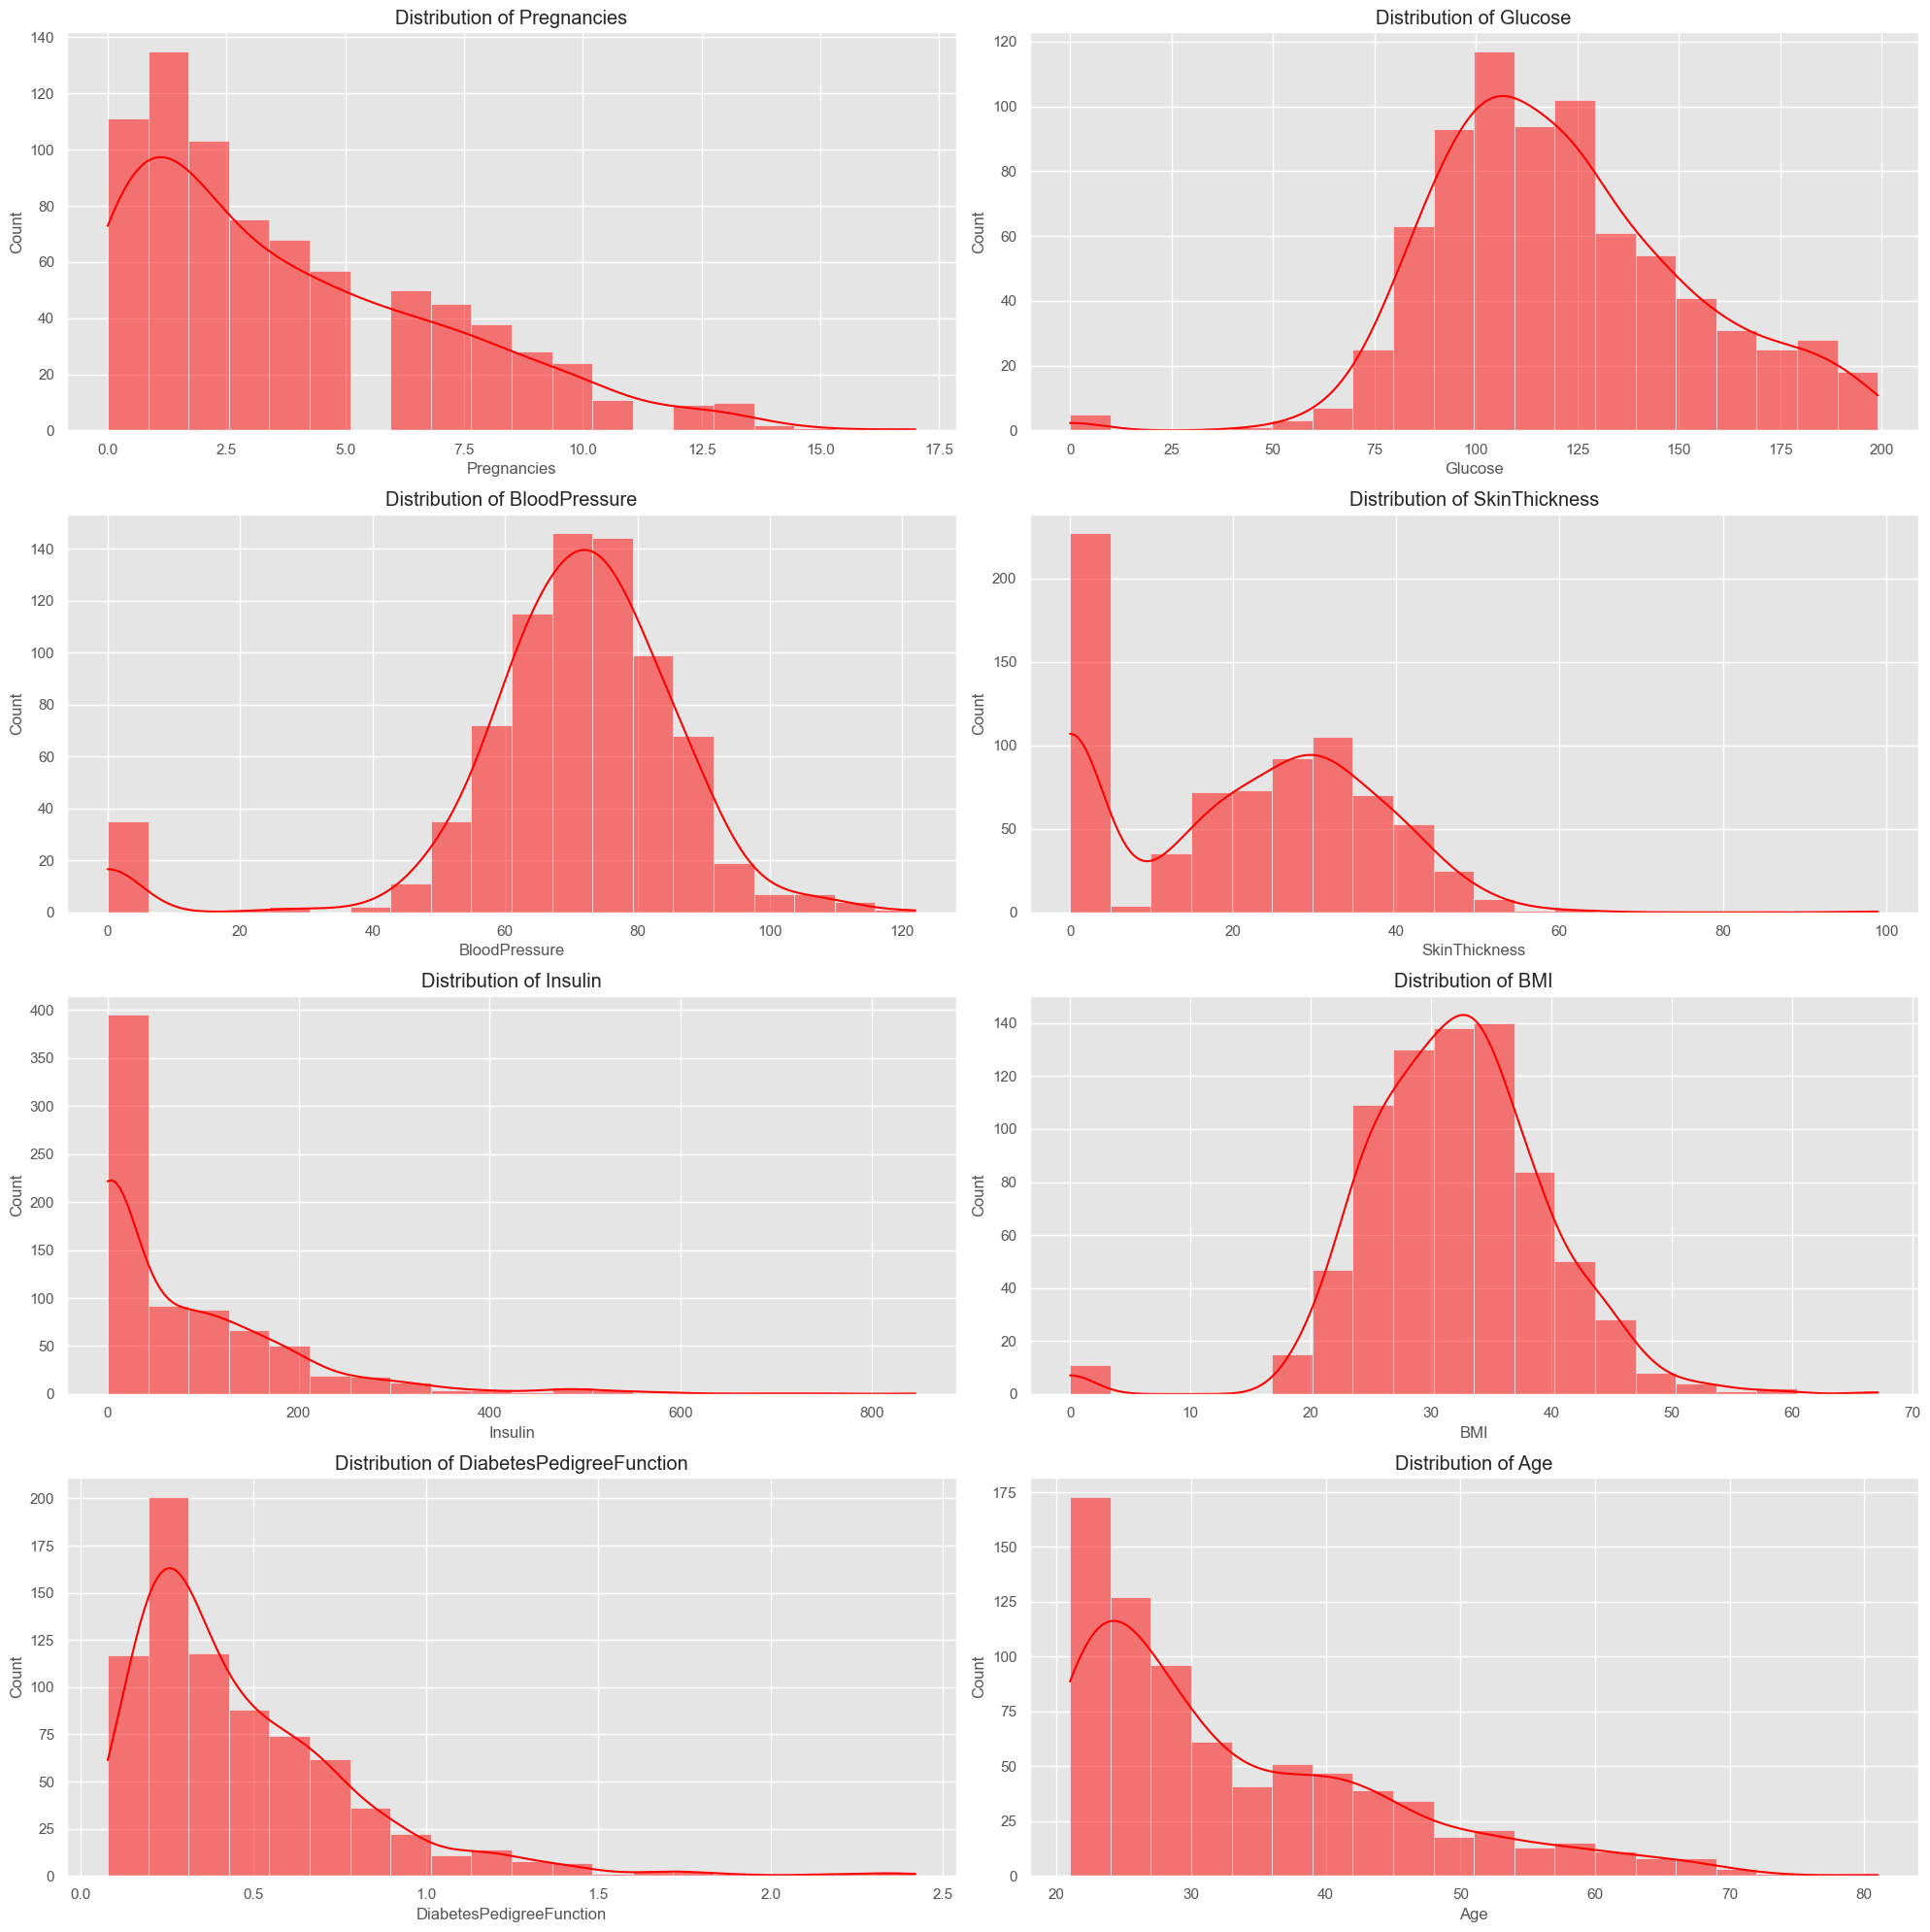

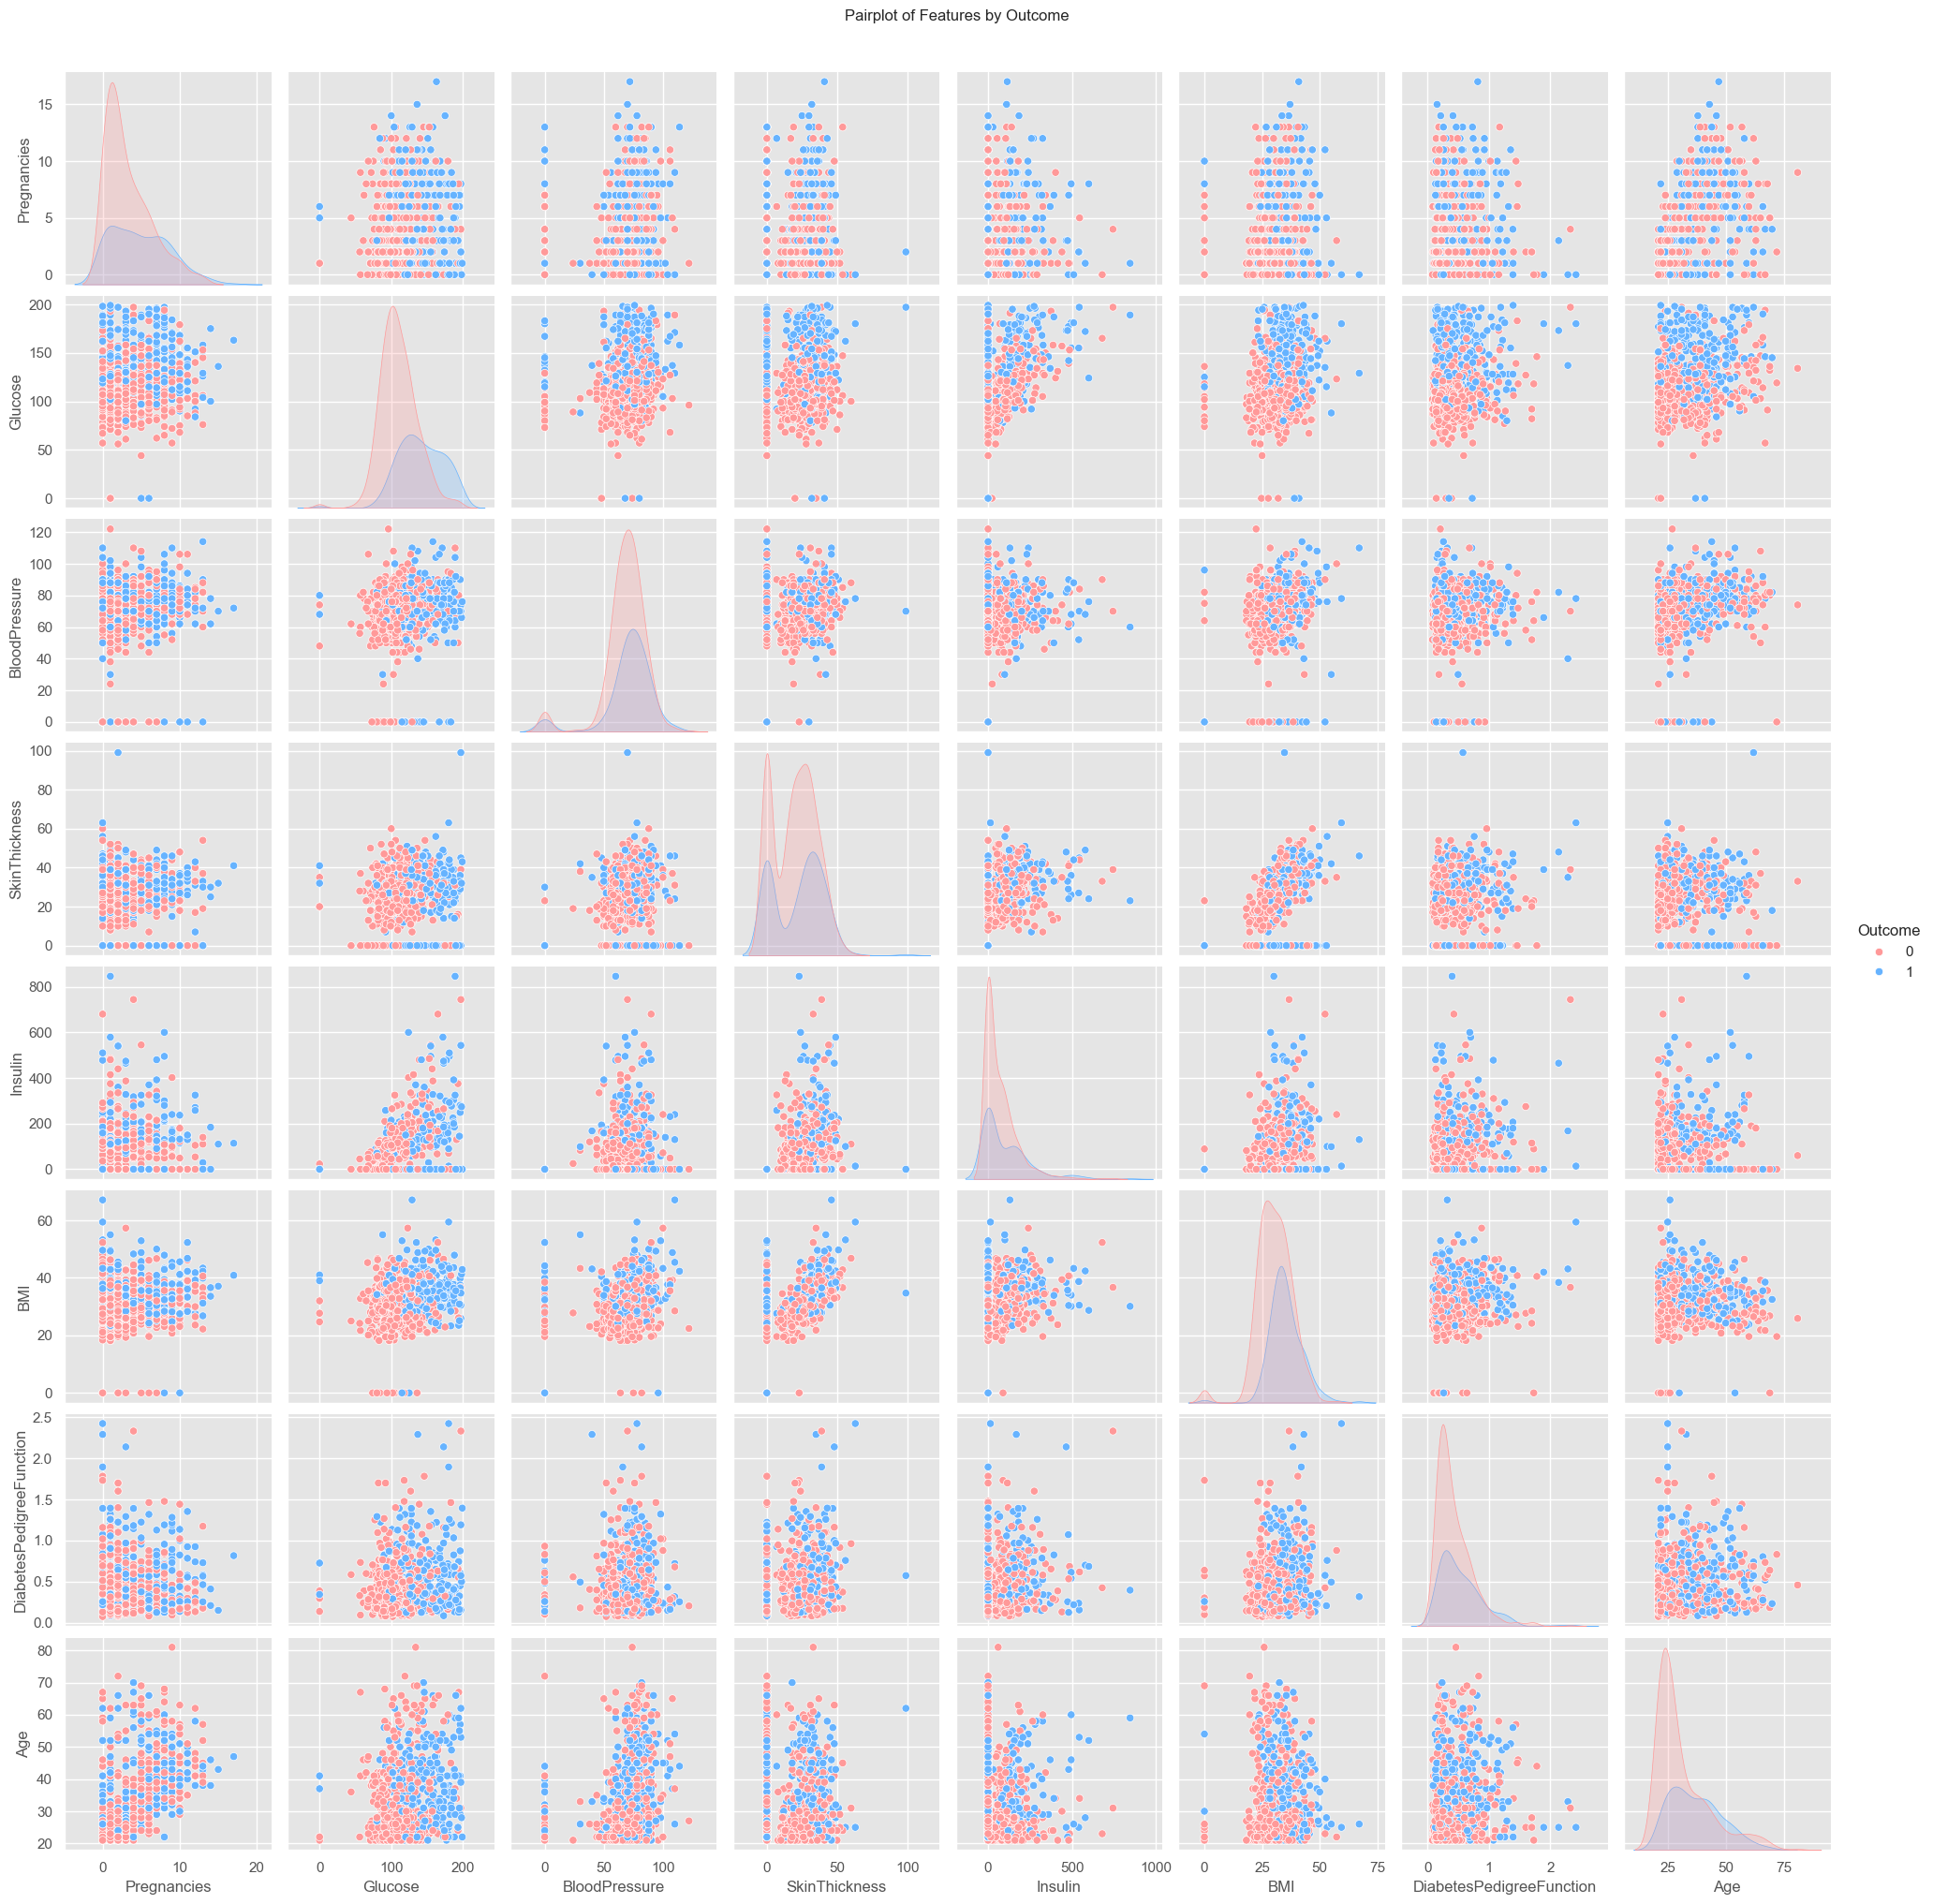

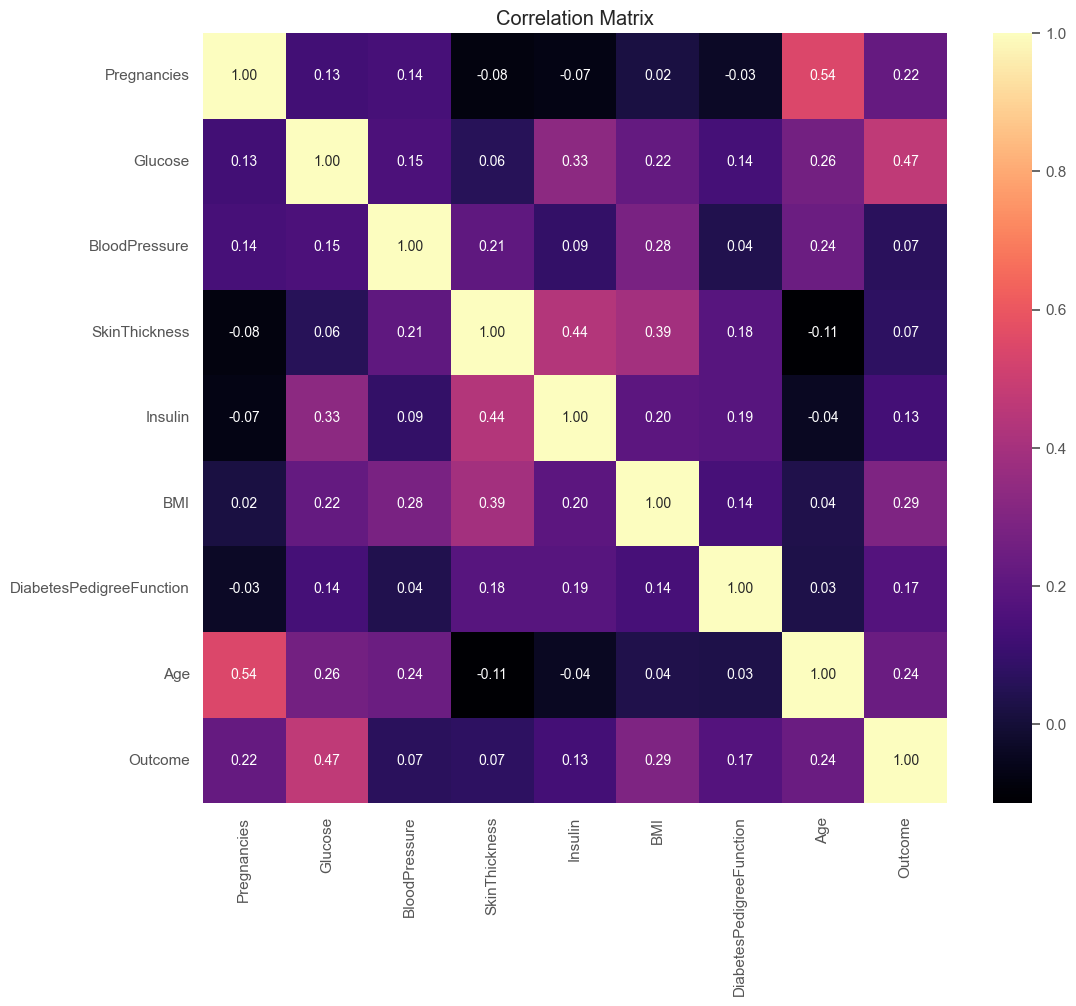

In [38]:
data_path = r"C:\Users\X1 CARBON TOUCH\Desktop\project-experiementation\Diabetes-Prediction\datasets\diabetes.csv"
df = pd.read_csv(data_path)

print("Data Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())
print("\nDataset Shape:", df.shape)

msno.bar(df, color="orange")
plt.title("Missing Data Overview")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14,6))
df['Outcome'].value_counts().plot.pie(autopct="%1.1f%%", colors=['#ff9999', '#66b3ff'],
                                       explode=[0, 0.1], shadow=True, ax=axes[0])
axes[0].set_title("Outcome Distribution (Pie Chart)")
axes[0].set_ylabel("")
sns.countplot(x='Outcome', data=df, palette=['#ff9999', '#66b3ff'], ax=axes[1])
axes[1].set_title("Outcome Count")
plt.show()

plt.figure(figsize=(8,6))
plt.hist(df['Age'], bins=20, edgecolor="black", color="skyblue")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show()

print("Max Age:", df['Age'].max())
print("Min Age:", df['Age'].min())

features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
            'DiabetesPedigreeFunction', 'Age']
fig, axes = plt.subplots(4, 2, figsize=(20,20))
for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    sns.histplot(df[feature], bins=20, kde=True, color="red", ax=axes[row, col])
    axes[row, col].set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

sns.pairplot(df, hue="Outcome", palette=['#ff9999', '#66b3ff'])
plt.suptitle("Pairplot of Features by Outcome", y=1.02)
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='magma')
plt.title("Correlation Matrix")
plt.show()

3. DATA CLEANING & PREPROCESSING

In [39]:
features_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[features_to_impute] = df[features_to_impute].replace(0, np.nan)
print("Missing values after replacing zeros:")
print(df.isnull().sum())

for col in features_to_impute:
    for outcome in df['Outcome'].unique():
        median_val = df[df['Outcome'] == outcome][col].median()
        df.loc[(df['Outcome'] == outcome) & (df[col].isnull()), col] = median_val

print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after replacing zeros:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


4. OUTLIER DETECTION & HANDLING

Removed outlier removal since the data was already small and applying to it outlier removal , would even make it more small
This can lead to overfitting of the model 

In [40]:
"""
plt.figure(figsize=(8,6))
sns.boxplot(x=df["Insulin"], color="red")
plt.title("Boxplot of Insulin Before Capping")
plt.show()

Q1 = df['Insulin'].quantile(0.25)
Q3 = df['Insulin'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
df.loc[df['Insulin'] > upper_bound, "Insulin"] = upper_bound

plt.figure(figsize=(7,6))
sns.boxplot(x=df["Insulin"], color="red")
plt.title("Boxplot of Insulin After Capping")
plt.show()

lof = LocalOutlierFactor(n_neighbors=10)
outlier_labels = lof.fit_predict(df.drop(columns=['Outcome']))
df = df[outlier_labels != -1]
print("Shape after LOF outlier removal:", df.shape)
"""

'\nplt.figure(figsize=(8,6))\nsns.boxplot(x=df["Insulin"], color="red")\nplt.title("Boxplot of Insulin Before Capping")\nplt.show()\n\nQ1 = df[\'Insulin\'].quantile(0.25)\nQ3 = df[\'Insulin\'].quantile(0.75)\nIQR = Q3 - Q1\nupper_bound = Q3 + 1.5 * IQR\ndf.loc[df[\'Insulin\'] > upper_bound, "Insulin"] = upper_bound\n\nplt.figure(figsize=(7,6))\nsns.boxplot(x=df["Insulin"], color="red")\nplt.title("Boxplot of Insulin After Capping")\nplt.show()\n\nlof = LocalOutlierFactor(n_neighbors=10)\noutlier_labels = lof.fit_predict(df.drop(columns=[\'Outcome\']))\ndf = df[outlier_labels != -1]\nprint("Shape after LOF outlier removal:", df.shape)\n'

5. MODEL PREPARATION: SPLITTING DATA

In [41]:
X = df.drop(columns=['Outcome'])
y = df['Outcome'] # type: ignore
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

6. TRAINING MULTIPLE MODELS & COMPARISON

7. only performing hyperparameter tunning for SVM and DT , since the other models take a lot of computing resources and time 

Best SVM Parameters: {'C': 0.5, 'gamma': 0.001}
Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 3, 'splitter': 'best'}
--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       100
           1       0.59      0.56      0.57        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.70      0.71      0.71       154

--- KNN ---
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       100
           1       0.80      0.76      0.78        54

    accuracy                           0.85       154
   macro avg       0.84      0.83      0.83       154
weighted avg       0.85      0.85      0.85       154

--- SVM ---
              prec

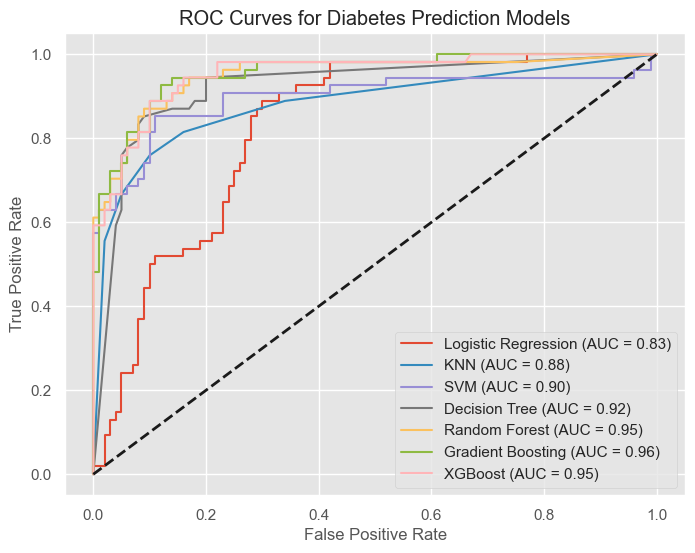

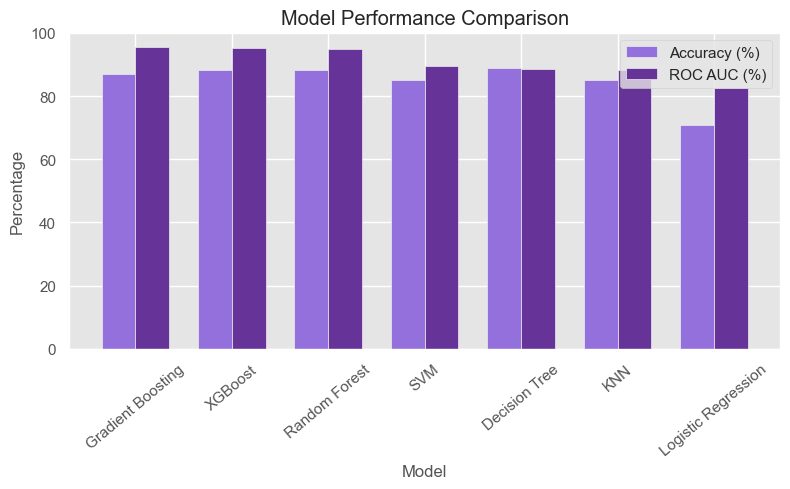

In [42]:
models_dict = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(criterion='entropy', max_depth=15,
                                              max_features=0.75, min_samples_leaf=2,
                                              min_samples_split=3, n_estimators=130,
                                              random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(objective='binary:logistic', learning_rate=0.01,
                             max_depth=10, n_estimators=180, use_label_encoder=False,
                             eval_metric='logloss')
}

# Hyperparameter tuning for SVM
svm_params = {"gamma": [0.0001, 0.001, 0.01, 0.1],
              "C": [0.01, 0.05, 0.5, 1, 10, 15, 20]}
grid_svm = GridSearchCV(SVC(probability=True), svm_params, cv=5)
grid_svm.fit(X_train, y_train)
models_dict["SVM"] = grid_svm.best_estimator_
print("Best SVM Parameters:", grid_svm.best_params_)

# Hyperparameter tuning for Decision Tree
dt_params = {'criterion': ['gini', 'entropy'],
             'max_depth': [3, 5, 7, 10],
             'splitter': ['best', 'random'],
             'min_samples_leaf': [1, 2, 3, 5, 7],
             'min_samples_split': [2, 3, 5, 7],
             'max_features': ['auto', 'sqrt', 'log2']}
grid_dt = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)
models_dict["Decision Tree"] = grid_dt.best_estimator_
print("Best Decision Tree Parameters:", grid_dt.best_params_)

model_performance = []
for name, model in models_dict.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    model_performance.append({
        "Model": name,
        "Accuracy (%)": 100 * round(acc, 4),
        "ROC AUC (%)": 100 * round(roc, 4)
    })
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    
performance_df = pd.DataFrame(model_performance).sort_values(by="ROC AUC (%)", ascending=False)
print("\nModel Comparison:")
print(performance_df)

plt.figure(figsize=(8,6))
for name, model in models_dict.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Diabetes Prediction Models")
plt.legend(loc="lower right")
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(len(performance_df))
bar_width = 0.35
acc_vals = performance_df["Accuracy (%)"].values
roc_vals = performance_df["ROC AUC (%)"].values
ax.bar(index, acc_vals, bar_width, label='Accuracy (%)', color='mediumpurple')
ax.bar(index + bar_width, roc_vals, bar_width, label='ROC AUC (%)', color='rebeccapurple')
ax.set_xlabel("Model")
ax.set_ylabel("Percentage")
ax.set_title("Model Performance Comparison")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(performance_df["Model"].values, rotation=40)
ax.legend()
plt.tight_layout()
plt.show()

8. FINAL PIPELINE CONSTRUCTION USING GRADIENT BOOSTING since it is ;
stable, interpretable, and efficient while maintaining strong classification performance, compared to the other models

In [43]:
# Custom transformer for feature engineering
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, epsilon=1e-5):  # Corrected constructor name
        self.epsilon = epsilon
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        data = X.copy()
        data['PregnancyRatio'] = data['Pregnancies'] / (data['Age'] + self.epsilon)
        data['RiskScore'] = (0.5 * data['Glucose'] + 0.3 * data['BMI'] + 0.2 * data['Age'])
        data['InsulinEfficiency'] = (data['Insulin'] + self.epsilon) / (data['Glucose'] + self.epsilon)
        data['Glucose_BMI'] = (data['Glucose'] + self.epsilon) / (data['BMI'] + self.epsilon)
        data['BMI_Age'] = data['BMI'] * data['Age']
        return data

# Custom transformer for WoE encoding with safe log computation
class WoEEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, epsilon=1e-5):  # Corrected constructor name
        self.epsilon = epsilon
        self.feature_bins = {
            'Pregnancies': [-np.inf, 1.7, 5.1, 8.5, np.inf],
            'Glucose': [-np.inf, 90.6, 119.4, 159.2, np.inf],
            'BMI': [-np.inf, 26.84, 38.26, np.inf],
            'RiskScore': [-np.inf, 55.61, 77.51, 99.41, np.inf],
        }
        self.woe_mappings = {}
        
    def fit(self, X, y):
        y = pd.Series(y, name='target')
        for feature, bins in self.feature_bins.items():
            X[f'{feature}_cat'] = pd.cut(X[feature], bins=bins)
            woe_df = self._calculate_woe(X, f'{feature}_cat', y)
            self.woe_mappings[feature] = woe_df.set_index(f'{feature}_cat')['WOE'].to_dict()
        return self
    
    def transform(self, X):
        data = X.copy()
        for feature in self.feature_bins.keys():
            data[f'{feature}_cat'] = pd.cut(data[feature], bins=self.feature_bins[feature])
            data[f'{feature}_woe'] = data[f'{feature}_cat'].map(self.woe_mappings[feature])
            data.drop(columns=[f'{feature}_cat'], inplace=True)
        return data
    
    def _calculate_woe(self, data, feature_name, y):
        data['target'] = y
        grouped = data.groupby(feature_name, observed=False)['target'].value_counts().unstack(fill_value=0)
        grouped.columns = ['non_events', 'events']
        grouped['event_rate'] = grouped['events'] / grouped['events'].sum()
        grouped['non_event_rate'] = grouped['non_events'] / grouped['non_events'].sum()
        grouped['WOE'] = np.log((grouped['event_rate'] + self.epsilon) / (grouped['non_event_rate'] + self.epsilon))
        return grouped.reset_index()

# Transformer to select desired columns
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):  # Corrected constructor name
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

selected_columns = [
    'Pregnancies', 'Glucose', 'BMI', 'PregnancyRatio',
    'RiskScore', 'InsulinEfficiency', 'Glucose_BMI', 'BMI_Age',
    'Glucose_woe', 'RiskScore_woe'
]

# Build the final pipeline using GradientBoostingClassifier.
final_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineering()),
    ('woe_encoding', WoEEncoding()),
    ('column_selector', ColumnSelector(selected_columns)),
    ('scaler', StandardScaler()),
    ('model', GradientBoostingClassifier(
         max_depth=15,
         n_estimators=130,
         criterion='friedman_mse',
         max_features=0.75,
         min_samples_leaf=2,
         min_samples_split=3,
         random_state=42))
])

final_cv_score = cross_val_score(final_pipeline, X, y, cv=cv, scoring='roc_auc').mean()
print(f"Final Pipeline Cross-Validated ROC AUC (GB): {final_cv_score:.4f}")
print(f"Final Pipeline Model-Accuracy (GB): {final_cv_score:.4f}")

final_pipeline.fit(X, y)
joblib.dump(final_pipeline, "diabetes_prediction_pipeline.joblib")
print("Final model pipeline saved as 'diabetes_prediction_pipeline.joblib'")

Final Pipeline Cross-Validated ROC AUC (GB): 0.9146
Final Pipeline Model-Accuracy (GB): 0.9146
Final model pipeline saved as 'diabetes_prediction_pipeline.joblib'


9. FEATURE IMPORTANCE PART

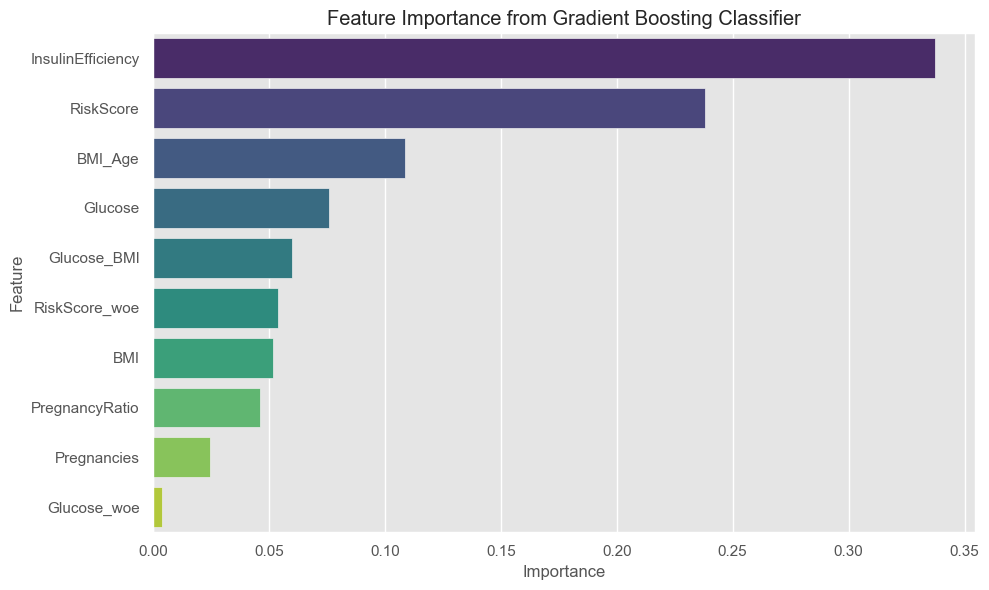

In [44]:
# Extract feature importance from the final model (Gradient Boosting)
importances = final_pipeline.named_steps["model"].feature_importances_
importance_df = pd.DataFrame({
    "Feature": selected_columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance from Gradient Boosting Classifier")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

10. GENERATE SHAP SUMMARY PLOT

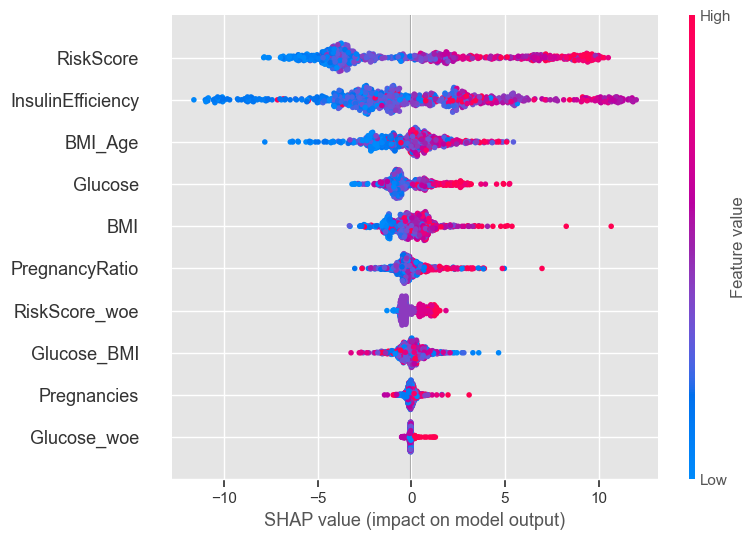

SHAP summary plot saved as 'summary_plot.png'


In [45]:
import shap # type: ignore

# (1) Transform X using pipeline steps up to but not including the final estimator
X_transformed = final_pipeline[:-1].transform(X)

# (2) Convert to DataFrame for correct feature names
X_transformed_df = pd.DataFrame(X_transformed, columns=selected_columns)

# (3) Create a TreeExplainer for the final model
explainer = shap.TreeExplainer(final_pipeline.named_steps["model"])

# (4) Compute SHAP values
shap_values = explainer.shap_values(X_transformed_df)

# (5) Generate & save SHAP summary plot with real feature names
shap.summary_plot(shap_values, X_transformed_df, plot_type="dot", show=False)
plt.savefig("summary_plot.png", bbox_inches="tight")
#plt.close() # Close the figure after saving
plt.show()  # (Optional) Display the plot if running interactively
print("SHAP summary plot saved as 'summary_plot.png'")